In [13]:
from typing import TypedDict, Annotated,Dict
from langgraph.graph import add_messages, StateGraph, END,START
from langchain_groq import ChatGroq
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
import os

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore
os.environ["TAVILY_API_KEY"] = os.getenv('Tavily') # type: ignore

In [2]:
from langchain_core.tools import tool

@tool
def web_search(query: str) -> str:
    """Search the web for current information and news."""
    tavily = TavilySearchResults(max_results=3)
    result = tavily.invoke(f"query: {query}")
    formatted_results = []
    
    if isinstance(result, list): 
        for item in result:
            if isinstance(item, dict): 
                title = item.get('title', 'No Title')
                url = item.get('url', 'No URL')
                content = item.get('content', 'No Content')
                truncated_content = (content[:200] + '...') if len(content) > 200 else content
                formatted_results.append(f"Title: {title}\nURL: {url}\nContent: {truncated_content}\n---")
    
    return f"Search Results:\n" + "\n".join(formatted_results)


In [ ]:

class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

# meta-llama/Llama-3.2-3B-Instruct-Turbo
llm = ChatGroq(model="llama-3.1-8b-instant")
tools = [web_search]
tool_node = ToolNode(tools=tools)
llm_with_tools = llm.bind_tools(tools=tools)

def agent(state: ChildState):
    response = llm_with_tools.invoke(state["messages"])
    print("-----------")
    if hasattr(response, 'tool_calls'):
        print(f"__agent__.Tool calls: {response.tool_calls}")
    print("-----------")
    state["messages"] = response
    return {
        "messages": [response], 
    }

def tools_router(state: ChildState):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        tool_calls = getattr(last_message, "tool_calls", None)
        print("-----------")
        print(f"__tools_router__.Tool calls: {tool_calls}")
        print("-----------")
        # return "tool_node"
        return "tools"
    else: 
        return END
    

In [4]:



subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tools", tool_node) 
subgraph.add_edge(START,"agent")

subgraph.add_edge("tools", "agent")
subgraph.add_conditional_edges("agent", tools_router,{"tools":"tools",END:END})
# subgraph.add_conditional_edges("agent", tools_condition)

search_app = subgraph.compile()

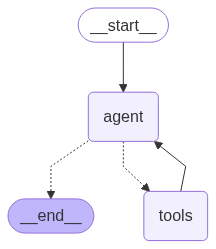

In [5]:
from IPython.display import Image, display

try:
    display(Image(search_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [6]:
search_app.invoke({"messages": [HumanMessage(content="How is the weather in Kolkata today?")]})

-----------
__agent__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Kolkata weather today'}, 'id': 'hehc8q36k', 'type': 'tool_call'}]
-----------
-----------
__tools_router__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Kolkata weather today'}, 'id': 'hehc8q36k', 'type': 'tool_call'}]
-----------


C:\Users\User\AppData\Local\Temp\ipykernel_3116\534120192.py:6: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults(max_results=3)


-----------
__agent__.Tool calls: []
-----------


{'messages': [HumanMessage(content='How is the weather in Kolkata today?', additional_kwargs={}, response_metadata={}, id='5472ddad-fbc6-41bc-9fb5-ea4785e60043'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hehc8q36k', 'function': {'arguments': '{"query":"Kolkata weather today"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 224, 'total_tokens': 242, 'completion_time': 0.337171922, 'prompt_time': 0.052463295, 'queue_time': 0.044279579000000006, 'total_time': 0.389635217}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--035df2af-3148-423a-9082-3ef6ee5738d8-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Kolkata weather today'}, 'id': 'hehc8q36k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 224, 'output_tokens': 18, 'total_tokens': 242}),
  ToolMessage(c

Shared Schema (Direct Embedding)

In [7]:


# Define parent graph with the same schema
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

# Create parent graph
parent_graph = StateGraph(ParentState)

# Add the subgraph as a node
parent_graph.add_node("search_agent", search_app)

# Connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

# Compile parent graph
parent_app = parent_graph.compile()

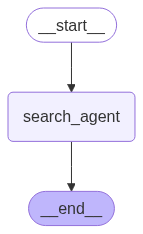

In [8]:
from IPython.display import Image, display

try:
    display(Image(parent_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
parent_app.invoke({"messages": [HumanMessage(content="How is the weather in Rishra,West Bengal today ? Any chances of rainfall ?")]})

-----------
__agent__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Rishra,West Bengal weather today and rainfall chances'}, 'id': 'r1tyfq090', 'type': 'tool_call'}]
-----------
-----------
__tools_router__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Rishra,West Bengal weather today and rainfall chances'}, 'id': 'r1tyfq090', 'type': 'tool_call'}]
-----------
-----------
__agent__.Tool calls: []
-----------


{'messages': [HumanMessage(content='How is the weather in Rishra,West Bengal today ? Any chances of rainfall ?', additional_kwargs={}, response_metadata={}, id='64113628-bd82-4717-ae25-823ae1d1d916'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'r1tyfq090', 'function': {'arguments': '{"query":"Rishra,West Bengal weather today and rainfall chances"}', 'name': 'web_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 234, 'total_tokens': 259, 'completion_time': 0.034207385, 'prompt_time': 1.085386836, 'queue_time': 0.045731554999999924, 'total_time': 1.119594221}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_510c177af0', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--02f5b537-6df5-483d-b67a-bc784c5502e5-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'Rishra,West Bengal weather today and rainfall chances'}, 'id': 'r1tyfq090', 'type': 'tool_cal

Different Schema (Invoke with Transformation)

In [14]:
class QueryState(TypedDict):
    query: str
    response: str

# Function to invoke subgraph
def search_agent(state: QueryState) -> Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages": [HumanMessage(content=state["query"])]
    }
    subgraph_result = search_app.invoke(subgraph_input)
    assistant_message = subgraph_result["messages"][-1]
    return {"response": assistant_message.content}

In [15]:
transformed_parent_graph = StateGraph(QueryState)

transformed_parent_graph.add_node("search_agent", search_agent)
transformed_parent_graph.add_edge(START, "search_agent")
transformed_parent_graph.add_edge("search_agent", END)

transformed_parent_app = transformed_parent_graph.compile()

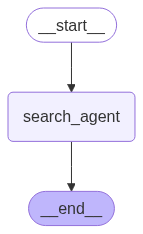

In [16]:
from IPython.display import Image, display

try:
    display(Image(transformed_parent_app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [17]:
transformed_parent_app.invoke({"query": "How is the road condition in Belghoria Expressway today?", "response": ""})

-----------
__agent__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Belghoria Expressway road condition today'}, 'id': 'h1n5rv3gg', 'type': 'tool_call'}]
-----------
-----------
__tools_router__.Tool calls: [{'name': 'web_search', 'args': {'query': 'Belghoria Expressway road condition today'}, 'id': 'h1n5rv3gg', 'type': 'tool_call'}]
-----------
-----------
__agent__.Tool calls: []
-----------


{'query': 'How is the road condition in Belghoria Expressway today?',
 'response': "Based on the search results, it appears that there are some issues with the road condition on the Belghoria Expressway today. There are reports of craters on the road, which are causing delays and making the commute difficult. However, it's not clear if the road condition is hazardous or just rough. It's always a good idea to check for real-time traffic updates or contact local authorities for the most up-to-date information."}